# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model

## Exploratory Data Analysis of NFIRS and SVI Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# Data Import and Cleaning

## NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [2]:
nfirs_path = '../data/raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['state','fdid','city','zip5','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

C:\Users\thwhi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Fix the tot_loss column which had incorrect data for 2015. Since tot_loss = prop_loss + cont_loss, it was easy enough to recalculate those values
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

In [4]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [5]:
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

In [6]:
nfirs.sample(5)

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire,had_inj,had_death,10k_loss
149103,NY,24001,New York City,10306,2009-04-22,0.0,0.0,0.0,0.0,0.0,36085027900.0,not_sev_fire,no_inj,no_death,no_10k_loss
814050,LA,32020,DENHAM SPRINGS,70706,2012-06-18,NaN,NaN,0.0,0.0,0.0,22063040301.0,not_sev_fire,no_inj,no_death,no_10k_loss
1312125,MI,00903,Bay City,48708,2014-01-08,NaN,NaN,0.0,0.0,0.0,26017280400.0,not_sev_fire,no_inj,no_death,no_10k_loss
1776661,MD,9031,Cambridge,21613,2016-01-01,NaN,NaN,0.0,0.0,0.0,24019970702.0,not_sev_fire,no_inj,no_death,no_10k_loss
432274,OK,63011,Shawnee,74801,2010-04-01,0.0,0.0,10000.0,0.0,10000.0,40125500200.0,sev_fire,no_inj,no_death,had_10k_loss


## Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [7]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [8]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [9]:
nfirs.head()

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire,had_inj,had_death,10k_loss
0,AK,11100,JUNEAU,99801,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500,sev_fire,no_inj,no_death,had_10k_loss
1,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600,not_sev_fire,no_inj,no_death,no_10k_loss
2,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100,sev_fire,no_inj,no_death,had_10k_loss
3,AK,11100,JUNEAU,99801,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400,not_sev_fire,no_inj,no_death,no_10k_loss
4,AK,11100,JUNEAU,99801,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400,sev_fire,no_inj,no_death,had_10k_loss


In [10]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

## SVI Data

In [11]:
svi2016_path = '../data/raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [12]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


## Fire Rates by County

- Task 1: <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 3: <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.

In [13]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','ST_ABBR','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

# create list of severe columns & total columns
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)
nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_counties_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_counties_rates = nfirs_svi_counties_rates[cols]

C:\Users\thwhi\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [14]:
nfirs_svi_counties_rates.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,55049.0,0.000459,0.000164,0.000123,0.000070,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000163,0.000490,0.000145
01003,AL,Baldwin,199510.0,0.000465,0.000099,0.000082,0.000023,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000085,0.000486,0.000075
01005,AL,Barbour,26614.0,0.000244,0.000143,0.000070,0.000093,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000000,0.000188,0.000038
01007,AL,Bibb,22572.0,0.000072,0.000062,0.000033,0.000031,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000133,0.000089
01009,AL,Blount,57704.0,0.000390,0.000196,0.000095,0.000060,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000069,0.000832,0.000087


## Fire rates by Census Tract

- Task 2: <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 4: <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population 

In [15]:
# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_tracts = pd.crosstab(nfirs['GEOID'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in nfirs['year'].unique():
    nfirs_tracts[(year,'tot_fires')] = nfirs_tracts[(year,'not_sev_fire')] + nfirs_tracts[(year,'sev_fire')]

# Sort the columns
nfirs_tracts = nfirs_tracts[sorted(nfirs_tracts.columns)]

# data already aggregated by census tract, so simply select the columns to merge
svi2016_tracts = svi2016[['FIPS','ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].set_index('FIPS')

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_tracts = svi2016_tracts.merge(nfirs_tracts,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_tracts_rates = nfirs_svi_tracts[['ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_tracts_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'tot_fires')] / nfirs_svi_tracts['E_TOTPOP']
    nfirs_svi_tracts_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'sev_fire')] / nfirs_svi_tracts['E_TOTPOP']

nfirs_svi_tracts_rates.index.name = 'GEOID'

# create list of severe columns & total columns
sev_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_tracts_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].std(axis=1)
nfirs_svi_tracts_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','LOCATION','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_tracts_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_tracts_rates = nfirs_svi_tracts_rates[cols]

# Exploratory Data Analysis

## Are the per capita fire rates for the various counties normally distributed?
    - No

Text(0.5, 0, 'Rate')

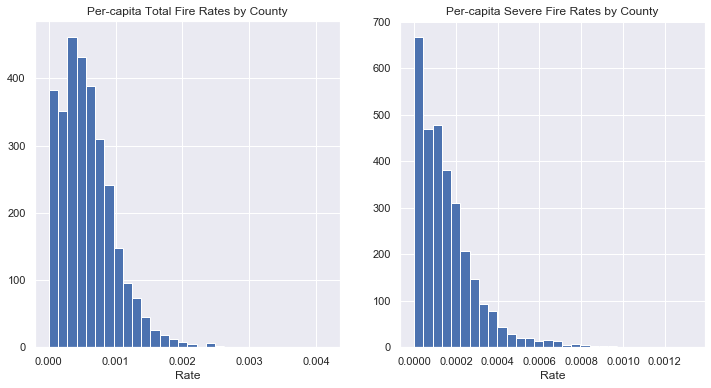

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches((12,6))

nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'].hist(bins=30, ax=ax1)
ax1.set_title('Per-capita Total Fire Rates by County')
ax1.set_xlabel('Rate')

nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'].hist(bins=30,ax=ax2)
ax2.set_title('Per-capita Severe Fire Rates by County')
ax2.set_xlabel('Rate')

## Is the difference in per-capita fire rates from year to year statistically significant?
    - 2015 vs 2016: Yes.

In [17]:
from scipy import stats

stats.ttest_rel(nfirs_svi_counties_rates['2015_tot_fire_rate_per_cap'],
                nfirs_svi_counties_rates['2016_tot_fire_rate_per_cap'],nan_policy='omit')

Ttest_relResult(statistic=-4.535322662882748, pvalue=5.976114971854253e-06)

## Total & Severe Fires by year

In [18]:
nfirs_svi_counties.head()

,E_TOTPOP,"(2009, not_sev_fire)","(2009, sev_fire)","(2009, tot_fires)","(2010, not_sev_fire)","(2010, sev_fire)","(2010, tot_fires)","(2011, not_sev_fire)","(2011, sev_fire)","(2011, tot_fires)","(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)"
STCNTY,,,,,,,,,,,,,,,,,,,,,,,,,
01001,55049.0,26.0,13.0,39.0,18.0,9.0,27.0,22.0,7.0,29.0,12.0,2.0,14.0,20.0,4.0,24.0,9.0,2.0,11.0,22.0,9.0,31.0,19.0,8.0,27.0
01003,199510.0,57.0,16.0,73.0,79.0,15.0,94.0,56.0,20.0,76.0,75.0,13.0,88.0,69.0,10.0,79.0,110.0,25.0,135.0,83.0,17.0,100.0,82.0,15.0,97.0
01005,26614.0,7.0,3.0,10.0,12.0,0.0,12.0,4.0,0.0,4.0,3.0,5.0,8.0,1.0,0.0,1.0,3.0,6.0,9.0,3.0,0.0,3.0,4.0,1.0,5.0
01007,22572.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,2.0,3.0
01009,57704.0,17.0,4.0,21.0,19.0,4.0,23.0,13.0,14.0,27.0,11.0,5.0,16.0,8.0,4.0,12.0,13.0,4.0,17.0,12.0,4.0,16.0,43.0,5.0,48.0


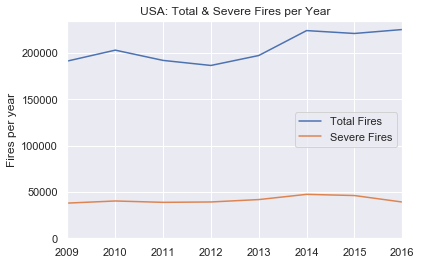

In [19]:
# Total Fires by Year for entire USA
years = list(range(2009,2017))
total_cols = [(year,'tot_fires') for year in years]
severe_cols = [(year,'sev_fire') for year in years]

fig,ax = plt.subplots()
nfirs_svi_counties[total_cols].sum().plot(ax=ax)
nfirs_svi_counties[severe_cols].sum().plot(ax=ax)
ax.set_ylim(0)
ax.legend(['Total Fires','Severe Fires'])
ax.set_ylabel('Fires per year')
ax.set_title('USA: Total & Severe Fires per Year')
a=ax.set_xticklabels(years)

## Total & Severe fires by state and year

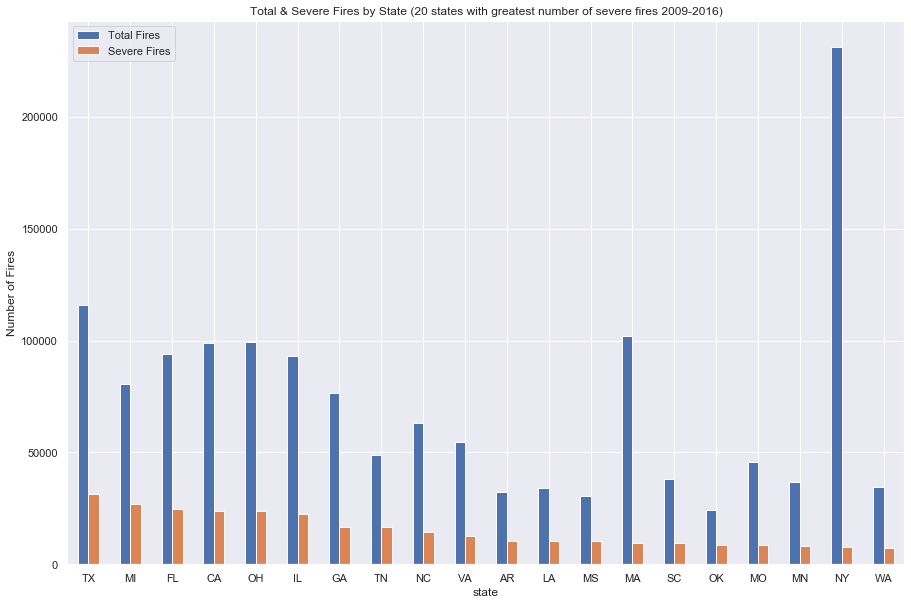

In [20]:
# Total & Severe fires by state, 2009-2016

state_fires = pd.crosstab(index=nfirs['state'],columns=nfirs['severe_fire'])
state_fires['total_fires'] = state_fires.sum(axis=1)

fig,ax1 = plt.subplots(1)
fig.set_size_inches((15,10))
state_fires[['total_fires','sev_fire']].sort_values('sev_fire',ascending=False)[:20].plot.bar(rot=0,ax=ax1)
ax1.set_title('Total & Severe Fires by State (20 states with greatest number of severe fires 2009-2016)')
ax1.set_ylabel('Number of Fires')
ax1.legend(['Total Fires','Severe Fires'])

In [21]:
top_10_states = state_fires['sev_fire'].sort_values(ascending=False)[:10].index

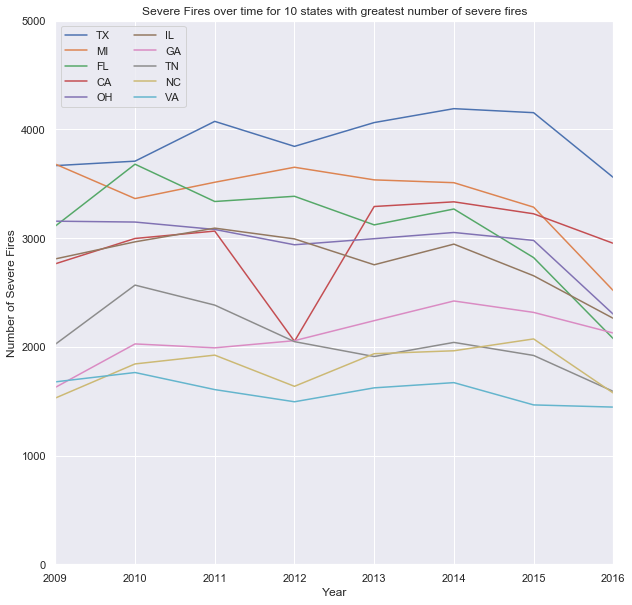

In [22]:
# Severe fires over time in worst states
state_fires_years = pd.crosstab(index=nfirs['state'],columns=[nfirs['year'],nfirs['severe_fire']])
years = list(range(2009,2017))

for year in years:
    state_fires_years[(year,'tot_fires')] = state_fires_years[(year,'not_sev_fire')] + state_fires_years[(year,'sev_fire')]

fig,ax = plt.subplots()
fig.set_size_inches(10,10)
sev_cols = [(year,'sev_fire') for year in range(2009,2017)]
# state_fires_years[sev_cols].sort_values((2016,'sev_fire'),ascending=False)[:10].transpose().plot(ax=ax)
state_fires_years[sev_cols].loc[top_10_states].transpose().plot(ax=ax)
ax.set_ylabel('Number of Severe Fires')
ax.set_xlabel('Year')
ax.set_title('Severe Fires over time for 10 states with greatest number of severe fires')
ax.set_ylim(0,5000)
plt.legend(loc='upper left',ncol=2)
a=ax.set_xticklabels(years)

## Seasonal characteristics of severe & total fires

In [23]:
fires_by_date = pd.crosstab(index=nfirs['inc_date'],columns=nfirs['severe_fire'])
fires_by_date['tot_fires'] = fires_by_date.sum(axis=1)

In [24]:
# Check if there are any missing dates in the fires_by_date dataframe.
pd.date_range(start='2009-01-01',end='2016-12-31').difference(fires_by_date.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [25]:
fires_by_date['tot_rolling_30day_avg'] = fires_by_date['tot_fires'].rolling(window=30).sum().shift(-15)
fires_by_date['sev_rolling_30day_avg'] = fires_by_date['sev_fire'].rolling(window=30).sum().shift(-15)

Text(0.5, 1.0, 'USA: Centered, Rolling 30 day average of total fires')

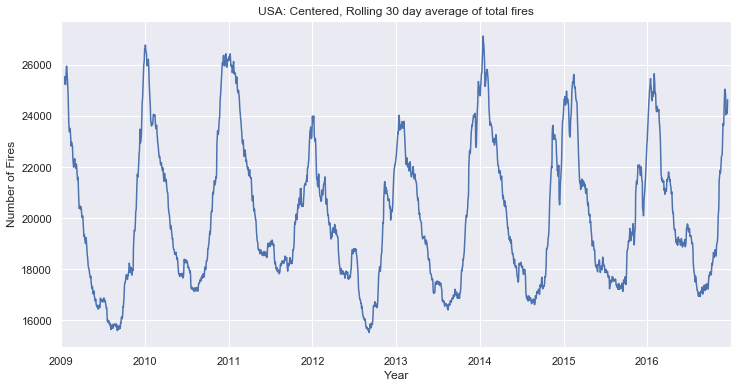

In [26]:
fig,ax1 = plt.subplots()
fig.set_size_inches(12,6)

fires_by_date['tot_rolling_30day_avg'].plot(ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fires')
ax1.set_title('USA: Centered, Rolling 30 day average of total fires')

Text(0.5, 1.0, 'USA: Centered, Rolling 30 day average of severe fires')

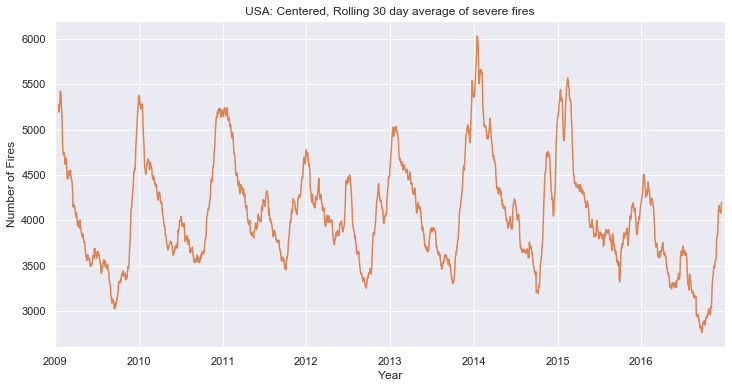

In [27]:
fig,ax2 = plt.subplots()
fig.set_size_inches(12,6)

fires_by_date['sev_rolling_30day_avg'].plot(ax=ax2,color=(221/255, 132/255, 82/255))
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Fires')
ax2.set_title('USA: Centered, Rolling 30 day average of severe fires')

## State fires by date

In [28]:
state_fires_by_date = pd.crosstab(index=nfirs['inc_date'],columns=[nfirs['state'],nfirs['severe_fire']])

states = state_fires_by_date.columns.get_level_values(0).unique()
for state in states:
    state_fires_by_date[(state,'tot_fires')] = state_fires_by_date[state].sum(axis=1)

for state in top_10_states:
    state_fires_by_date[(state,'30day_centered_avg')] = state_fires_by_date[(state,'sev_fire')].rolling(window=30).sum().shift(-15)

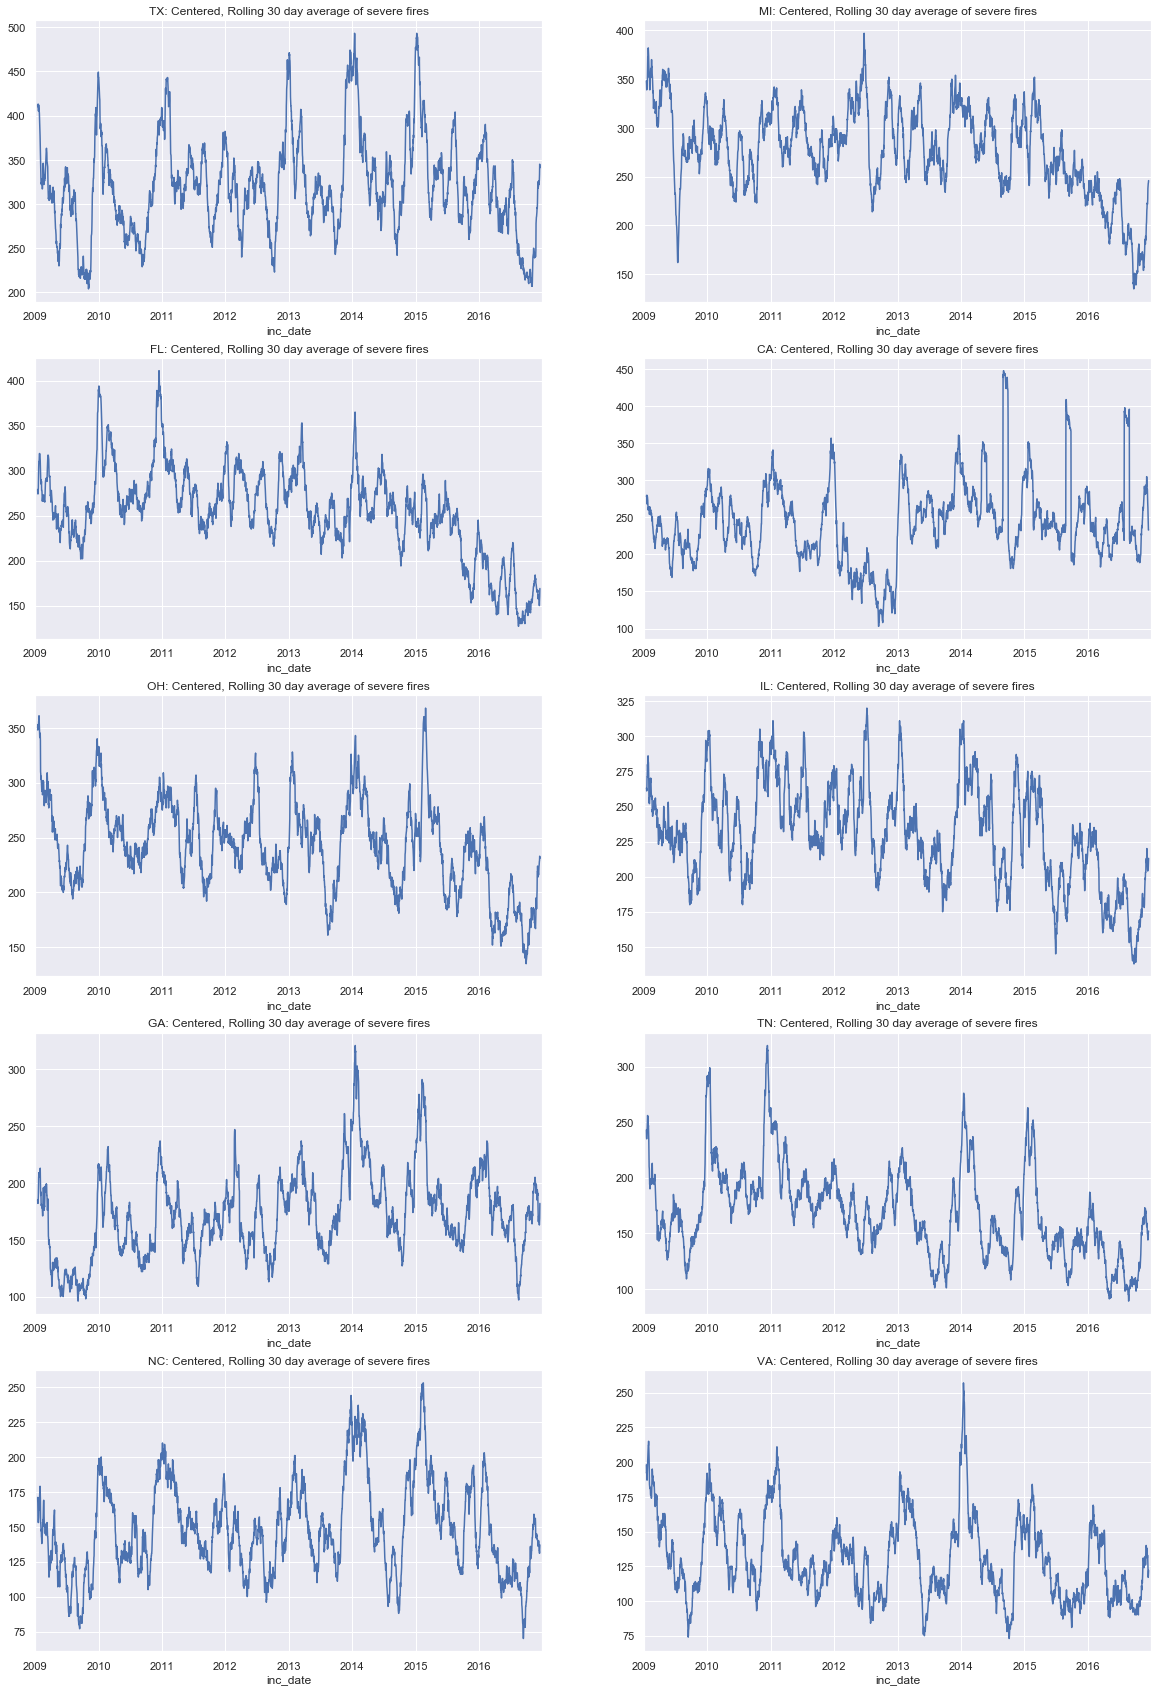

In [29]:
top_10_states_sev = [(state,'30day_centered_avg') for state in top_10_states]

fig,axes = plt.subplots(5,2)
fig.set_size_inches(20,30)

for state,ax in zip(top_10_states,fig.axes):
    state_fires_by_date[(state,'30day_centered_avg')].plot(ax=ax)
    ax.set_title(state + ': Centered, Rolling 30 day average of severe fires')

# Aggregate by Fire Department

Add fire department unique id's to the NFIRS dataframe and aggregate by fire dept unique ID

In [30]:
fire_depts = pd.read_csv('../Data/raw/FD Locations.csv')

In [31]:
fire_depts['st_fdid'] = fire_depts['STATE'] + fire_depts['FDID'].astype(str)
nfirs['st_fdid'] = nfirs['state'] + nfirs['fdid'].astype(str)

In [32]:
# join on st_fdid
nfirs = nfirs.merge(fire_depts[['st_fdid','Unique ID']].drop_duplicates(subset=['st_fdid']),how='left',on='st_fdid',validate='many_to_one')

In [33]:
nfirs['Unique ID'].isnull().sum()

699220

## There were a huge number of rows in nfirs without a matching state & fdid in the fire_depts dataframe (~700,000)
So I decided to just look at the st_fdid from nfirs instead

In [34]:
# Zero-pad the fdid numbers to the correct length. The FDID manual suggests that this should be used
nfirs['fdid2'] = nfirs['fdid'].str.zfill(5)
nfirs['st_fdid2'] = nfirs['state'] + nfirs['fdid2']

# Frequency table
nfirs_fdid = pd.crosstab(nfirs['st_fdid2'],[nfirs['year'],nfirs['severe_fire']])

# Add tot_fires columns
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_fdid[(year,'tot_fires')] = nfirs_fdid[(year,'not_sev_fire')] + nfirs_fdid[(year,'sev_fire')]
nfirs_fdid = nfirs_fdid[sorted(nfirs_fdid.columns)]

# column list to use
year_tot_fires_cols = [(year, 'tot_fires') for year in [2009,2010,2011,2012,2013,2014,2015,2016]]

In [35]:
nfirs_fdid[year_tot_fires_cols].sort_values((2009,'tot_fires'),ascending=False).head(10)

year,2009,2010,2011,2012,2013,2014,2015,2016
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires
st_fdid2,,,,,,,,
ILCS931,3837,4253,4079,3910,3909,3754,3561,3393
MA25035,2791,2830,0,2726,2812,2901,2755,0
TN79553,1290,1611,0,1125,43,1081,1273,870
MD25001,1282,1224,1187,995,899,1022,1072,0
TXKA926,1041,1387,1285,1007,1000,1232,1246,1101
TXWB901,677,603,642,625,650,557,551,469
TXAW824,632,574,667,359,556,500,737,660
TXWP801,525,511,495,395,406,433,426,251


In [36]:
fraction_with_zeros = (nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1).sum() / nfirs_fdid.shape[0]
print('{:.3} of the fire department id’s have at least one year in which they reported 0 fires'.format(fraction_with_zeros))

0.94 of the fire department id’s have at least one year in which they reported 0 fires


## Fire Dept Data Issue - Lots of years with 0 fires reported

In [37]:
nfirs_fdid[year_tot_fires_cols][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)].sort_values((2009,'tot_fires'),ascending=False).head(10)

year,2009,2010,2011,2012,2013,2014,2015,2016
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires
st_fdid2,,,,,,,,
MA25035,2791,2830,0,2726,2812,2901,2755,0
TN79553,1290,1611,0,1125,43,1081,1273,870
MD25001,1282,1224,1187,995,899,1022,1072,0
LA36001,524,559,610,215,513,500,445,0
VA05900,500,642,623,368,668,637,0,0
MA13281,480,499,0,455,397,380,295,0
MA27348,463,487,0,496,490,537,553,0
MA17049,418,440,0,473,415,423,425,0


In [38]:
# Ok, now that I've got the fire data aggregated by fire department, even though it is very poor, perhaps I can glean some interesting information from it.
# Aside from just data quality issues.

In [39]:
nfirs_fdid['sum_tot_fires'] = nfirs_fdid[year_tot_fires_cols].sum(axis=1)

In [40]:
(nfirs_fdid[nfirs_fdid['sum_tot_fires'] > 1000][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)]
 .sort_values('sum_tot_fires',ascending=False)[list(year_tot_fires_cols) + [('sum_tot_fires','')]].head(10))

C:\Users\thwhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


year,2009,2010,2011,2012,2013,2014,2015,2016,sum_tot_fires
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,
st_fdid2,,,,,,,,,
NY24001,0,0,0,0,0,0,20579,0,20579
MA25035,2791,2830,0,2726,2812,2901,2755,0,16815
MI08207,0,0,3464,0,3856,3547,3104,0,13971
MD25001,1282,1224,1187,995,899,1022,1072,0,7681
TN79553,1290,1611,0,1125,43,1081,1273,870,7293
MO09545,0,0,886,0,1087,1348,1401,0,4722
WI40200,0,680,965,0,973,379,855,0,3852
VA05900,500,642,623,368,668,637,0,0,3438


## Fraction of depts reporting 0 fires each year

In [41]:
# The number of fire departments reporting 0 total fires each year
no_fire_fdids = pd.DataFrame((nfirs_fdid[year_tot_fires_cols] == 0).sum())

no_fire_fdids = no_fire_fdids.reset_index().set_index('year').drop('severe_fire',axis=1)

no_fire_fdids.columns = ['depts_with_0_fires']

no_fire_fdids['fraction_with_0_fires'] = no_fire_fdids['depts_with_0_fires'] / nfirs_fdid.shape[0]

In [42]:
no_fire_fdids

,depts_with_0_fires,fraction_with_0_fires
year,,
2009,13362,0.634563
2010,11689,0.555112
2011,13186,0.626205
2012,15264,0.724890
2013,12809,0.608301
2014,12244,0.581469
2015,4867,0.231135
2016,16976,0.806193


Text(0.5, 1.0, 'Fraction of fire departments reporting 0 fires in a given year')

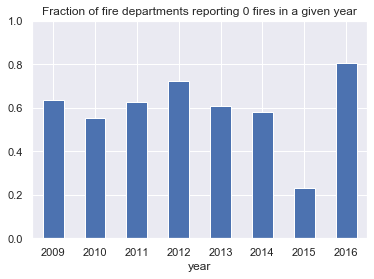

In [43]:
fig,ax = plt.subplots()
no_fire_fdids['fraction_with_0_fires'].plot.bar(ax=ax,rot=0)
ax.set_ylim((0,1))
ax.set_title('Fraction of fire departments reporting 0 fires in a given year')

In [44]:
# The fraction of fire departments which reported fewer than 10 fires during the whole time period. This suggests that a large 
# fraction of the fire departments are smaller & deal with a small amount of fires over time.
(nfirs_fdid['sum_tot_fires'] < 10).sum() / nfirs_fdid.shape[0]

0.5009260578429976

Text(0.5, 1.0, 'Histogram of total number of fires reported in NFIRS by a given fire department')

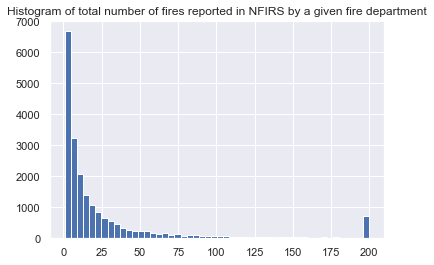

In [45]:
fig,ax = plt.subplots()
nfirs_fdid['sum_tot_fires'].clip(0,200).hist(bins = 50,ax=ax)
ax.set_title('Histogram of total number of fires reported in NFIRS by a given fire department')

In [46]:
nfirs_svi_tracts.sample(5)

,ST_ABBR,COUNTY,LOCATION,E_TOTPOP,"(2009, not_sev_fire)","(2009, sev_fire)","(2009, tot_fires)","(2010, not_sev_fire)","(2010, sev_fire)","(2010, tot_fires)","(2011, not_sev_fire)","(2011, sev_fire)","(2011, tot_fires)","(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)"
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48453001805,TX,Travis,"Census Tract 18.05, Travis County, Texas",4889.0,2.0,1.0,3.0,3.0,3.0,6.0,7.0,0.0,7.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,4.0,1.0,0.0,1.0,3.0,0.0,3.0
25005645101,MA,Bristol,"Census Tract 6451.01, Bristol County, Massachu...",4674.0,5.0,0.0,5.0,1.0,0.0,1.0,6.0,0.0,6.0,14.0,0.0,14.0,4.0,0.0,4.0,5.0,0.0,5.0,4.0,0.0,4.0,6.0,0.0,6.0
36047064200,NY,Kings,"Census Tract 642, Kings County, New York",2360.0,4.0,0.0,4.0,21.0,0.0,21.0,8.0,0.0,8.0,8.0,0.0,8.0,4.0,0.0,4.0,14.0,0.0,14.0,4.0,0.0,4.0,6.0,0.0,6.0
55057100700,WI,Juneau,"Census Tract 1007, Juneau County, Wisconsin",3940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
31033954900,NE,Cheyenne,"Census Tract 9549, Cheyenne County, Nebraska",4265.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0


# Task B2
- <b>Home Fire Area Profiles</b>: Use SVI data to identify common demographic and economic themes for Census Tract areas reporting fires. Document methodolgy and results

What features might correlate with 

Only use data from 2012 - 2016 which corresponds to the years for the data collected in the SVI dataset.

In [47]:
cols_2012_2016 = [col for col in list(nfirs_svi_tracts.columns) if col[0] not in [2009,2010,2011]]

In [48]:
nfirs_svi_tracts = nfirs_svi_tracts[cols_2012_2016]

nfirs_svi_tracts = nfirs_svi_tracts.merge(svi2016.drop(['ST_ABBR','COUNTY','LOCATION','E_TOTPOP'],axis=1),how='left',left_index=True,right_on='FIPS')

nfirs_svi_tracts = nfirs_svi_tracts.replace(-999.0,np.nan)
nfirs_svi_tracts = nfirs_svi_tracts.rename(columns={'FIPS':'GEOID'})
nfirs_svi_tracts = nfirs_svi_tracts.set_index('GEOID')

In [49]:
nfirs_svi_tracts.head()

,ST_ABBR,COUNTY,LOCATION,E_TOTPOP,"(2012, not_sev_fire)","(2012, sev_fire)","(2012, tot_fires)","(2013, not_sev_fire)","(2013, sev_fire)","(2013, tot_fires)","(2014, not_sev_fire)","(2014, sev_fire)","(2014, tot_fires)","(2015, not_sev_fire)","(2015, sev_fire)","(2015, tot_fires)","(2016, not_sev_fire)","(2016, sev_fire)","(2016, tot_fires)",ST,STATE,STCNTY,AREA_SQMI,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01015981902,AL,Calhoun,"Census Tract 9819.02, Calhoun County, Alabama",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,ALABAMA,01015,34.644448,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,NaN,NaN,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,335.0
01015981903,AL,Calhoun,"Census Tract 9819.03, Calhoun County, Alabama",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,ALABAMA,01015,13.929908,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,NaN,NaN,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,0.0
01097990000,AL,Mobile,"Census Tract 9900, Mobile County, Alabama",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,ALABAMA,01097,0.000000,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,NaN,NaN,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,0.0
01117980000,AL,Shelby,"Census Tract 9800, Shelby County, Alabama",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,ALABAMA,01117,13.634818,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,NaN,NaN,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [50]:
cols_to_drop = [(year,'not_sev_fire') for year in range(2012,2017)]

nfirs_svi_tracts = nfirs_svi_tracts.drop(cols_to_drop,axis=1)

new_fire_cols = [str(year) + '_' + fire_type for (year,fire_type) in nfirs_svi_tracts.columns[4:14]]
new_fire_cols = [name + 's' if name[-1] != 's' else name for name in new_fire_cols]
new_cols = list(nfirs_svi_tracts)[:4] + new_fire_cols + list(nfirs_svi_tracts)[4+len(new_fire_cols):]
nfirs_svi_tracts.columns = new_cols

tot_fire_cols = [str(year) + '_tot_fires' for year in range(2012,2017)]
sev_fire_cols = [str(year) + '_sev_fires' for year in range(2012,2017)]

nfirs_svi_tracts['sum_sev_fires'] = nfirs_svi_tracts[sev_fire_cols].sum(axis=1)
nfirs_svi_tracts['sum_tot_fires'] = nfirs_svi_tracts[tot_fire_cols].sum(axis=1)

In [51]:
more_cols_to_drop = [col for col in list(nfirs_svi_tracts.columns) if 'M_' in col or 'MP_' in col]
nfirs_svi_tracts = nfirs_svi_tracts.drop(more_cols_to_drop,axis=1)

## Distribution of Total & Severe Fire frequencies (2012-2016)

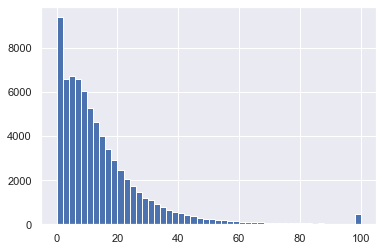

In [59]:
nfirs_svi_tracts['sum_tot_fires'].clip(0,100).hist(bins=50)

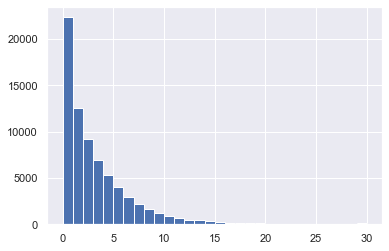

In [145]:
nfirs_svi_tracts['sum_sev_fires'].clip(0,30).hist(bins=30)

In [62]:
nfirs_svi_tracts[['sum_sev_fires','sum_tot_fires']].describe()

,sum_sev_fires,sum_tot_fires
count,72836.00,72836.00
mean,2.93,14.46
std,4.10,17.63
min,0.00,0.00
25%,0.00,4.00
50%,2.00,10.00
75%,4.00,19.00
max,165.00,538.00


## Total & Severe Fire Rates Correlations

In [116]:
def plot_correlation_matrix_heat_map(df,label,qty_fields=10):
    df = pd.concat([df[label],df.drop(label,axis=1)],axis=1)
    correlation_matrix = df.corr()
    index = correlation_matrix.sort_values(label, ascending=False).index
    correlation_matrix = correlation_matrix[index].sort_values(label,ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches((10,10))
    sns.heatmap(correlation_matrix.iloc[:qty_fields,:qty_fields],annot=True,fmt='.2f',ax=ax)
    return(fig,ax,correlation_matrix.iloc[:qty_fields,:qty_fields])

In [128]:
def print_var_descriptions(corr_matrix):
    names = corr_matrix.index[1:]
    for name in names:
        print(svi_dict2[name]) if name in svi_dict2 else print(name)

In [77]:
svi_total_cols = [col for col in nfirs_svi_tracts.columns if 'E_' in col]
svi_percent_cols = [col for col in nfirs_svi_tracts.columns if 'EP_' in col]
svi_percentile_cols = [col for col in nfirs_svi_tracts.columns if 'EPL_' in col]
svi_flag_cols = [col for col in nfirs_svi_tracts.columns if 'F_' in col]

print('svi_total_cols: ',svi_total_cols)
print('\nsvi_percent_cols: ',svi_percent_cols)
print('\nsvi_percentile_cols: ',svi_percentile_cols)
print('\nsvi_flag_cols',svi_flag_cols)

svi_total_cols:  ['E_TOTPOP', 'E_HU', 'E_HH', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP', 'E_AGE65', 'E_AGE17', 'E_DISABL', 'E_SNGPNT', 'E_MINRTY', 'E_LIMENG', 'E_MUNIT', 'E_MOBILE', 'E_CROWD', 'E_NOVEH', 'E_GROUPQ', 'E_UNINSUR', 'E_DAYPOP']

svi_percent_cols:  ['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'EP_UNINSUR']

svi_percentile_cols:  ['EPL_POV', 'EPL_UNEMP', 'EPL_PCI', 'EPL_NOHSDP', 'EPL_AGE65', 'EPL_AGE17', 'EPL_DISABL', 'EPL_SNGPNT', 'EPL_MINRTY', 'EPL_LIMENG', 'EPL_MUNIT', 'EPL_MOBILE', 'EPL_CROWD', 'EPL_NOVEH', 'EPL_GROUPQ']

svi_flag_cols ['F_POV', 'F_UNEMP', 'F_PCI', 'F_NOHSDP', 'F_THEME1', 'F_AGE65', 'F_AGE17', 'F_DISABL', 'F_SNGPNT', 'F_THEME2', 'F_MINRTY', 'F_LIMENG', 'F_THEME3', 'F_MUNIT', 'F_MOBILE', 'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL']


In [182]:
# Import the data dictionary, which was created from the svi 2016 documentation
import json
with open('../data/raw/svi_dictionary.json','r') as f:
    svi_dict = json.load(f)

# dictionary that includes the code in the value
svi_dict2 = {}
for key,val in svi_dict.items():
    svi_dict2[key] = key + ': ' + val

### Total Fires vs. SVI Factors

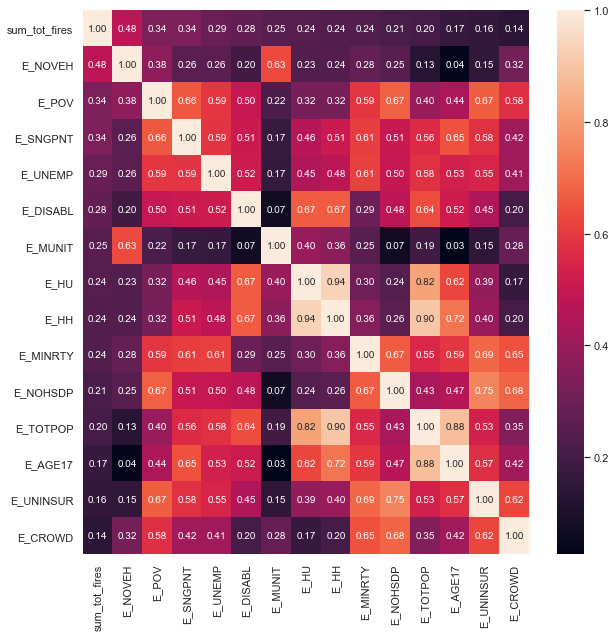

In [121]:
fig,ax,corr_matrix = plot_correlation_matrix_heat_map(nfirs_svi_tracts[list(svi_total_cols) + ['sum_tot_fires']],'sum_tot_fires',15)

In [129]:
print_var_descriptions(corr_matrix)

E_NOVEH: Households with no vehicle available estimate, 2012-2016 ACS
E_POV: Persons below poverty estimate, 2012-2016 ACS
E_SNGPNT: Single parent household with children under 18 estimate, 2012-2016 ACS
E_UNEMP: Civilian (age 16+) unemployed estimate, 2012-2016 ACS
E_DISABL: Civilian noninstitutionalized population with a disability estimate, 2012-2016 ACS
E_MUNIT: Housing in structures with 10 or more units estimate, 2012-2016 ACS
E_HU: Housing units estimate, 2012-2016 ACS
E_HH: Households estimate, 2012-2016 ACS
E_MINRTY: Minority (all persons except white, non-Hispanic) estimate, 2012-2016 ACS
E_NOHSDP: Persons (age 25+) with no high school diploma estimate, 2012-2016 ACS
E_TOTPOP: Population estimate, 2012-2016 ACS
E_AGE17: Persons aged 17 and younger estimate, 2012-2016 ACS
E_UNINSUR: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate, 2012-2016 ACS
E_CROWD: At household level (occupied housing units), more people than rooms estimate, 201

### Severe fires vs. SVI Factors

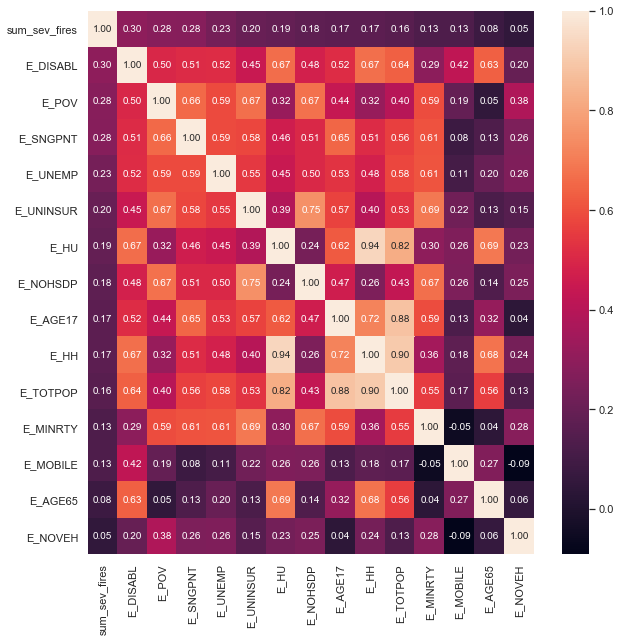

In [134]:
fig,ax,corr_matrix = plot_correlation_matrix_heat_map(nfirs_svi_tracts[list(svi_total_cols) + ['sum_sev_fires']],'sum_sev_fires',15)

In [137]:
print_var_descriptions(corr_matrix)

E_DISABL: Civilian noninstitutionalized population with a disability estimate, 2012-2016 ACS
E_POV: Persons below poverty estimate, 2012-2016 ACS
E_SNGPNT: Single parent household with children under 18 estimate, 2012-2016 ACS
E_UNEMP: Civilian (age 16+) unemployed estimate, 2012-2016 ACS
E_UNINSUR: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate, 2012-2016 ACS
E_HU: Housing units estimate, 2012-2016 ACS
E_NOHSDP: Persons (age 25+) with no high school diploma estimate, 2012-2016 ACS
E_AGE17: Persons aged 17 and younger estimate, 2012-2016 ACS
E_HH: Households estimate, 2012-2016 ACS
E_TOTPOP: Population estimate, 2012-2016 ACS
E_MINRTY: Minority (all persons except white, non-Hispanic) estimate, 2012-2016 ACS
E_MOBILE: Mobile homes estimate, 2012-2016 ACS
E_AGE65: Persons aged 65 and older estimate, 2012-2016 ACS
E_NOVEH: Households with no vehicle available estimate, 2012-2016 ACS


### Total Fires vs. SVI Factors for tracts with at least 10 total fires

In [138]:
nfirs_svi_top_tot_tracts = nfirs_svi_tracts[nfirs_svi_tracts['sum_tot_fires'] > 10]

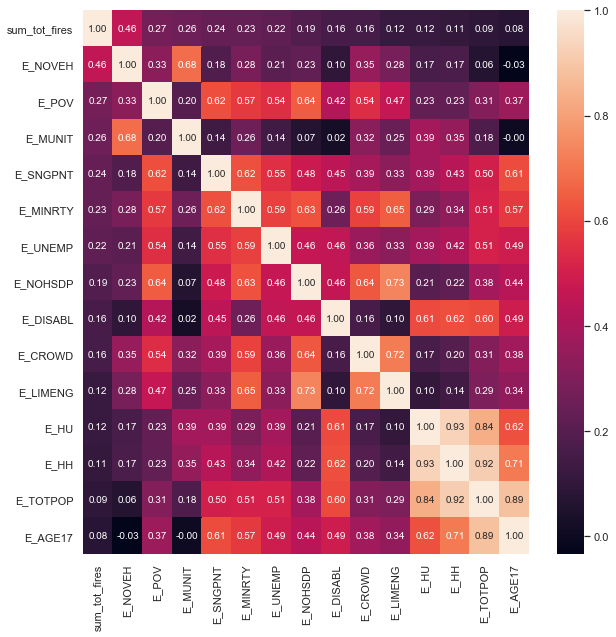

In [139]:
fig,ax,corr_matrix = plot_correlation_matrix_heat_map(nfirs_svi_top_tot_tracts[list(svi_total_cols) + ['sum_tot_fires']],'sum_tot_fires',15)

In [141]:
print_var_descriptions(corr_matrix)

E_NOVEH: Households with no vehicle available estimate, 2012-2016 ACS
E_POV: Persons below poverty estimate, 2012-2016 ACS
E_SNGPNT: Single parent household with children under 18 estimate, 2012-2016 ACS
E_UNEMP: Civilian (age 16+) unemployed estimate, 2012-2016 ACS
E_DISABL: Civilian noninstitutionalized population with a disability estimate, 2012-2016 ACS
E_MUNIT: Housing in structures with 10 or more units estimate, 2012-2016 ACS
E_HU: Housing units estimate, 2012-2016 ACS
E_HH: Households estimate, 2012-2016 ACS
E_MINRTY: Minority (all persons except white, non-Hispanic) estimate, 2012-2016 ACS
E_NOHSDP: Persons (age 25+) with no high school diploma estimate, 2012-2016 ACS
E_TOTPOP: Population estimate, 2012-2016 ACS
E_AGE17: Persons aged 17 and younger estimate, 2012-2016 ACS
E_UNINSUR: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate, 2012-2016 ACS
E_CROWD: At household level (occupied housing units), more people than rooms estimate, 201

### Severe Fires vs. SVI Factors for tracts with at least 10 total fires

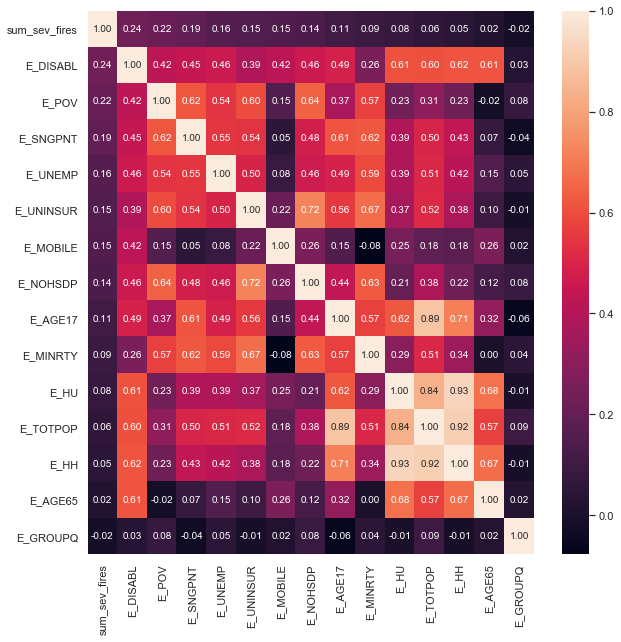

In [146]:
fig,ax,corr_matrix = plot_correlation_matrix_heat_map(nfirs_svi_top_tot_tracts[list(svi_total_cols) + ['sum_sev_fires']],'sum_sev_fires',15)

In [147]:
print_var_descriptions(corr_matrix)

E_DISABL: Civilian noninstitutionalized population with a disability estimate, 2012-2016 ACS
E_POV: Persons below poverty estimate, 2012-2016 ACS
E_SNGPNT: Single parent household with children under 18 estimate, 2012-2016 ACS
E_UNEMP: Civilian (age 16+) unemployed estimate, 2012-2016 ACS
E_UNINSUR: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate, 2012-2016 ACS
E_MOBILE: Mobile homes estimate, 2012-2016 ACS
E_NOHSDP: Persons (age 25+) with no high school diploma estimate, 2012-2016 ACS
E_AGE17: Persons aged 17 and younger estimate, 2012-2016 ACS
E_MINRTY: Minority (all persons except white, non-Hispanic) estimate, 2012-2016 ACS
E_HU: Housing units estimate, 2012-2016 ACS
E_TOTPOP: Population estimate, 2012-2016 ACS
E_HH: Households estimate, 2012-2016 ACS
E_AGE65: Persons aged 65 and older estimate, 2012-2016 ACS
E_GROUPQ: Persons in institutionalized group quarters estimate, 2012-2016 ACS


## Per-capita Fire rate correlations

In [151]:
nfirs_svi_tracts['sum_sev_fires_per_capita'] = nfirs_svi_tracts['sum_sev_fires'] / nfirs_svi_tracts['E_TOTPOP']
nfirs_svi_tracts['sum_tot_fires_per_capita'] = nfirs_svi_tracts['sum_tot_fires'] / nfirs_svi_tracts['E_TOTPOP']

In [155]:
nfirs_svi_tracts['sum_tot_fires_per_capita'].describe()

count    7.245300e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.096491e-03
50%      2.417405e-03
75%      4.546193e-03
max               inf
Name: sum_tot_fires_per_capita, dtype: float64

Text(0.5, 0, 'Total fires per person from 2012-2016')

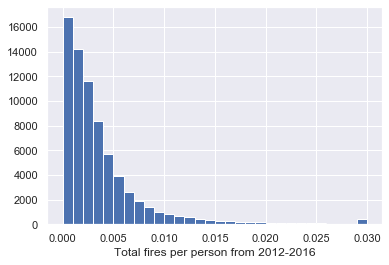

In [164]:
fig,ax = plt.subplots()
nfirs_svi_tracts['sum_tot_fires_per_capita'].clip(0,.03).hist(bins=30,ax=ax)
ax.set_xlabel('Total fires per person from 2012-2016')

Text(0.5, 0, 'Severe fires per person from 2012-2016')

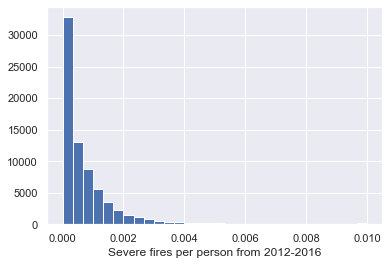

In [165]:
fig,ax = plt.subplots()
nfirs_svi_tracts['sum_sev_fires_per_capita'].clip(0,.01).hist(bins=30,ax=ax)
ax.set_xlabel('Severe fires per person from 2012-2016')

### Per-capita Total Fire Rate vs. SVI Factors

In [ ]:
svi_percent_cols

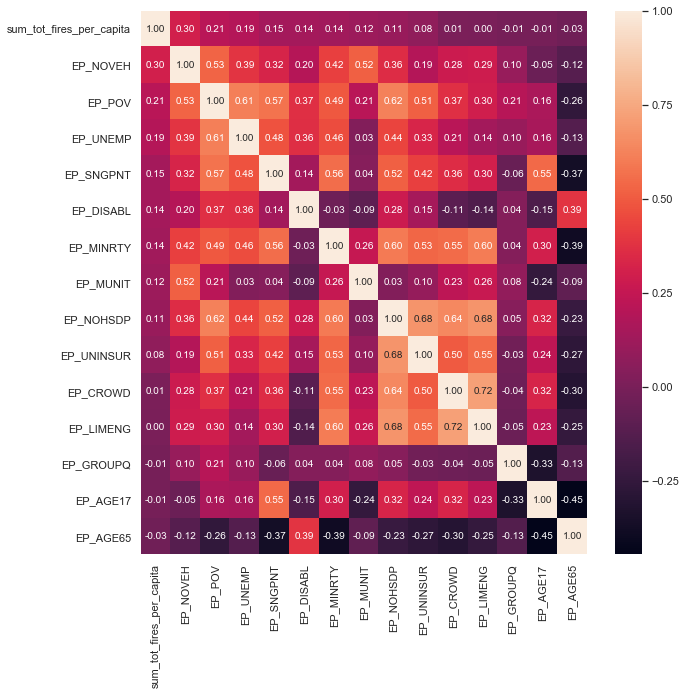

In [171]:
fig,ax,corr_matrix = plot_correlation_matrix_heat_map(nfirs_svi_tracts[list(svi_percent_cols) + ['sum_tot_fires_per_capita']],'sum_tot_fires_per_capita',15)

In [174]:
print_var_descriptions(corr_matrix)

EP_NOVEH: Percentage of households with no vehicle available estimate
EP_POV: Percentage of persons below poverty estimate
EP_UNEMP: Percentage of civilian (age 16+) unemployed estimate
EP_SNGPNT: Percentage of single parent households with children under 18 estimate, 2012-2016 ACS
EP_DISABL: Percentage of civilian noninstitutionalized population with a disability estimate, 2012-2016 ACS
EP_MINRTY: Percentage minority (all persons except white, non-Hispanic) estimate, 2012-2016 ACS
EP_MUNIT: Percentage of housing in structures with 10 or more units estimate
EP_NOHSDP: Percentage of persons with no high school diploma (age 25+) estimate
EP_UNINSUR: Adjunct variable - Percentage uninsured in the total civilian noninstitutionalized population estimate, 2012-2016 ACS
EP_CROWD: Percentage of occupied housing units with more people than rooms estimate
EP_LIMENG: Percentage of persons (age 5+) who speak English "less than well" estimate, 2012-2016 ACS
EP_GROUPQ: Percentage of persons in insti

### Per-capita Severe Fire Rate vs. SVI Factors

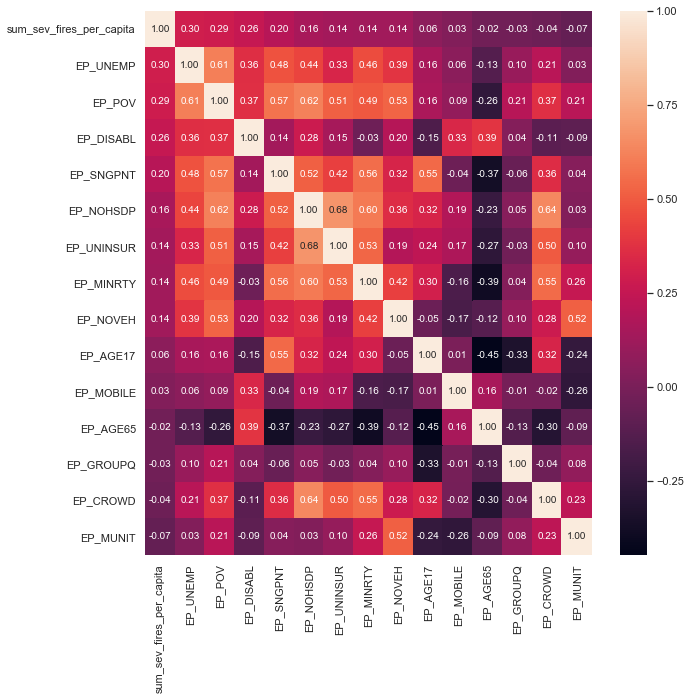

In [180]:
fig,ax,corr_matrix = plot_correlation_matrix_heat_map(nfirs_svi_tracts[list(svi_percent_cols) + ['sum_sev_fires_per_capita']],'sum_sev_fires_per_capita',15)

In [183]:
print_var_descriptions(corr_matrix)

EP_UNEMP: Percentage of civilian (age 16+) unemployed estimate
EP_POV: Percentage of persons below poverty estimate
EP_DISABL: Percentage of civilian noninstitutionalized population with a disability estimate, 2012-2016 ACS
EP_SNGPNT: Percentage of single parent households with children under 18 estimate, 2012-2016 ACS
EP_NOHSDP: Percentage of persons with no high school diploma (age 25+) estimate
EP_UNINSUR: Adjunct variable - Percentage uninsured in the total civilian noninstitutionalized population estimate, 2012-2016 ACS
EP_MINRTY: Percentage minority (all persons except white, non-Hispanic) estimate, 2012-2016 ACS
EP_NOVEH: Percentage of households with no vehicle available estimate
EP_AGE17: Percentage of persons aged 17 and younger estimate, 2012-2016 ACS
EP_MOBILE: Percentage of mobile homes estimate
EP_AGE65: Percentage of persons aged 65 and older estimate, 2012-2016 ACS
EP_GROUPQ: Percentage of persons in institutionalized group quarters estimate, 2012-2016 ACS
EP_CROWD: Per